In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import h5py
from scipy import interpolate
from ccfj import GetStationPairs
import pandas as pd
import yaml
import geopandas as gp
import openpyxl
from openpyxl import load_workbook
from concurrent.futures import ThreadPoolExecutor

from scipy.interpolate import make_interp_spline
from scipy.stats import ks_2samp
from scipy.spatial import ConvexHull
from skimage import measure

import warnings

In [2]:
import sys
sys.path.append(r'../tools_F-J/')
from toollib_standard import plotlib

In [3]:
#name_project = 'project/output_FJSJ_17-01/'               
name_project = 'project_repartition_v3.0/output_repar_v9.1_test/'               
name_project

'project_repartition_v3.0/output_repar_v9.1_test/'

In [4]:
with open('0_config.yml', 'r', encoding='utf-8') as f:
    dir_config = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_project_workspace = dir_config['dir_project_workspace']
dir_CC_workspace = dir_config['dir_CC_workspace']
print('dir_CC_workspace: ', dir_CC_workspace)
print('dir_project_workspace: ', dir_project_workspace)
dir_project = os.path.join(dir_project_workspace, name_project)
print('dir_project: ', dir_project)

dir_CC_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project:  /shdisk/rem2/Harmon/F-J/San/project_repartition_v3.0/output_repar_v9.1_test/


In [5]:
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

In [6]:
key_subworks = info_basic['key_subworks']
key_subworks

['2--09-03',
 '3--10-03',
 '4--11-03',
 '5--12-03',
 '6--13-03',
 '7--14-03',
 '8--15-03',
 '9--16-03',
 '10--18-03',
 '11--19-03',
 '12--20-03',
 '13--21-03',
 '14--22-03',
 '15--23-03',
 '16--24-03',
 '17--25-03',
 '18--26-03']

In [7]:
dir_image = dir_project+info_basic['dir_image'] + 'autopick/'
if not os.path.exists(dir_image):
    os.makedirs(dir_image)
dir_ds = dir_project+info_basic['dir_ds']
print('dir_image: ', dir_image)
print('dir_ds: ', dir_ds)

dir_image:  /shdisk/rem2/Harmon/F-J/San/project_repartition_v3.0/output_repar_v9.1_test/image_v9.1_test/
dir_ds:  /shdisk/rem2/Harmon/F-J/San/project_repartition_v3.0/output_repar_v9.1_test/ds_v9.1_test/


In [8]:
dir_disp =  'autopick'+info_basic['tag']+'/'
info_basic['dir_disp'] = dir_disp
dir_disp = dir_project+dir_disp
if not os.path.exists(dir_disp):
    os.makedirs(dir_disp)
print('dir_disp: ', dir_disp)

dir_disp:  /shdisk/rem2/Harmon/F-J/San/project_repartition_v3.0/output_repar_v9.1_test/autopickv9.1_test/


In [9]:
with open(dir_project+'Basic_info.yml', 'w', encoding='utf-8') as f:
   yaml.dump(data=info_basic, stream=f, allow_unicode=True)

### Pick probes' Phase velocity automatically

In [10]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [11]:
def cluster_fundamental(ds):
    global f
    global c
    global f_new
    global c_new
    global dir_ds
    global threshold
    # 归一化
    ds = np.nan_to_num(ds)
    for i in range(ds.shape[1]):
        ds[:,i] = ds[:,i]/np.max(ds[:,i])

    binary_ds = ds > threshold
    label_ds,num_labels = measure.label(binary_ds, connectivity=2, return_num=True)
    region_areas = [np.sum(label_ds==i) for i in range(1,num_labels+1)]
    if num_labels == 0:
        return np.zeros(0),np.zeros(0)
    max_area_label = np.argmax(region_areas) + 1
    largest_cluster = label_ds == max_area_label
    indices = np.argwhere(largest_cluster)

    ff = f_new[indices[:,1]]
    cc = c_new[indices[:,0]]

    return ff,cc

In [12]:
def pick_fundamental(key):
    global f
    global c
    global f_new
    global c_new
    global flag_f
    global flag_c
    global dir_ds
    global threshold
    global dir_disp
    global dir_ds
    global info_basic
    global info_basic_bi
    global smooth_cluster
    global smooth_pick
    global key_subworks
    global ds_remove_all

    
    ds_remove = ds_remove_all[key]
    grace = 0.0

    f_start = flag_f[0]
    f_end = flag_f[1]
    c_min = flag_c[0]
    c_max = flag_c[1]

    ff_all = []
    cc_all = []


    while f_start != f_end:
        #print(f_start,f_end)
        f_new = f[np.logical_and(f>f_start,f <= f_end)]
        c_new = c[np.logical_and(c>c_min,c < c_max)]
        ds_new0 = ds_remove[np.logical_and(c>c_min,c < c_max),:]
        ds_new = ds_new0[:,np.logical_and(f>f_start,f <= f_end)]
        # 对数组进行横向的平滑
        ds_new = pd.DataFrame(ds_new)
        #ds_new = ds_new.rolling(100).mean()
        ds_new = ds_new.T
        ds_new = ds_new.rolling(smooth_cluster).mean()
        ds_new = np.array(ds_new)
        ds_new = ds_new.T
        ff,cc = cluster_fundamental(ds_new)
        if len(ff_all) == 0:
            ff_all = ff
            cc_all = cc
        elif len(ff) != 0:
            ff_all = np.hstack((ff_all,ff))
            cc_all = np.hstack((cc_all,cc))
        else:
            #print('this')
            break
        f_start = np.max(ff)
        c_max = np.max(cc[ff==f_start]) + grace
    
    # smooth
    # 转置
    ds_smooth = ds_remove.T
    ds_smooth = pd.DataFrame(ds_smooth)
    ds_smooth = ds_smooth.rolling(smooth_pick).mean()
    ds_smooth = np.array(ds_smooth)
    ds_smooth = ds_smooth.T
    ds_smooth = pd.DataFrame(ds_smooth)
    ds_smooth = ds_smooth.rolling(smooth_pick).mean()
    ds_smooth = np.array(ds_smooth)

    f_range = set(ff_all)
    f_range = list(f_range)
    c_pick = []
    for i in range(len(f_range)):
        f_this = f_range[i]
        c_this = cc_all[ff_all==f_this]
        c_range = [np.min(c_this),np.max(c_this)]
        c_new = c[np.logical_and(c>=c_range[0],c<=c_range[1])]
        c_pick.append(c_new[np.argmax(ds_smooth[np.logical_and(c>=c_range[0],c<=c_range[1]),f==f_this])])
    
    # save as txt
    np.savetxt(dir_disp+'autopick_cluster_'+key+'.txt', np.array([ff_all,cc_all]).T, fmt='%.4f', delimiter=',')
    np.savetxt(dir_disp+'autopick_'+key+'.txt', np.array([f_range,c_pick]).T, fmt='%.4f', delimiter=',')
    print('finish '+ key + ' '+str(key_subworks.index(key)+1) + '/'+str(len(key_subworks)))

In [13]:
"""
key_subworks_all = info_basic['key_subworks']
key_subworks = []
for key in key_subworks_all:
    if int(key[0:2]) >= 46:
        key_subworks.append(key)
key_subworks = ['51-17--646']
key_subworks = info_basic['key_subworks'][600:]
key_subworks
"""

"\nkey_subworks_all = info_basic['key_subworks']\nkey_subworks = []\nfor key in key_subworks_all:\n    if int(key[0:2]) >= 46:\n        key_subworks.append(key)\nkey_subworks = ['51-17--646']\nkey_subworks = info_basic['key_subworks'][600:]\nkey_subworks\n"

In [14]:
ds_remove_all = {}
for key_subwork in key_subworks:
    ds = h5py.File(dir_ds+'ds_'+key_subwork+'.h5', 'r')
    ds_remove = ds['ds_remove'][0]
    ds.close()
    ds_remove_all[key_subwork] = ds_remove

In [15]:
f = info_basic_bi['f']
c = np.linspace(info_basic['c_min'],info_basic['c_max'],info_basic['c_num'])
flag_c = [0.1,1.5]
flag_f = [2.5,20]
threshold = 0.5
f_new = f[np.logical_and(f>flag_f[0],f < flag_f[1])]
c_new = c[np.logical_and(c>flag_c[0],c < flag_c[1])]
smooth_cluster = 3
smooth_pick = 1
flag_pick = 1

In [16]:
warnings.filterwarnings("ignore")
if flag_pick == 1:
    for key_subwork in key_subworks:
        pick_fundamental(key_subwork)

finish 2--09-03 1/17
finish 3--10-03 2/17
finish 4--11-03 3/17
finish 5--12-03 4/17
finish 6--13-03 5/17
finish 7--14-03 6/17
finish 8--15-03 7/17
finish 9--16-03 8/17
finish 10--18-03 9/17
finish 11--19-03 10/17
finish 12--20-03 11/17
finish 13--21-03 12/17
finish 14--22-03 13/17
finish 15--23-03 14/17
finish 16--24-03 15/17
finish 17--25-03 16/17
finish 18--26-03 17/17


In [17]:
def plot_disp(key_subwork):
    global dir_disp
    global f
    global c
    global dir_image

    fig,ax = plt.subplots(1,2,figsize=(16,6))
    dir_ds = dir_project + info_basic['dir_ds']
    ds = h5py.File(dir_ds+'ds_'+key_subwork+'.h5', 'r')
    ds_remove = ds['ds_remove'][0]

    title0 = key_subwork
    ff_all = np.loadtxt(dir_disp+'autopick_cluster_'+key_subwork+'.txt',delimiter=',')[:,0]
    cc_all = np.loadtxt(dir_disp+'autopick_cluster_'+key_subwork+'.txt',delimiter=',')[:,1]
    f_pick = np.loadtxt(dir_disp+'autopick_'+key_subwork+'.txt',delimiter=',')[:,0]
    c_pick = np.loadtxt(dir_disp+'autopick_'+key_subwork+'.txt',delimiter=',')[:,1]

    ax[0] = plotlib.plot_fj(ax[0],ds_remove,title0,f,c,0,c_map='jet')
    ax[0].scatter(ff_all,cc_all,marker='o',s=10,color='k')
    
    ax[1] = plotlib.plot_fj(ax[1],ds_remove,title0,f,c,0,c_map='jet')
    ax[1].scatter(f_pick,c_pick,marker='o',s=10,color='k')

    plt.savefig(dir_image+'autopick_'+key_subwork+'.png',dpi=60)
    plt.tight_layout()
    #plt.close()
    print('finish '+key_subwork)

In [19]:
flag_plot = 1

In [20]:
key_subworks = key_subworks[0:3]

finish 2--09-03
finish 3--10-03
finish 4--11-03


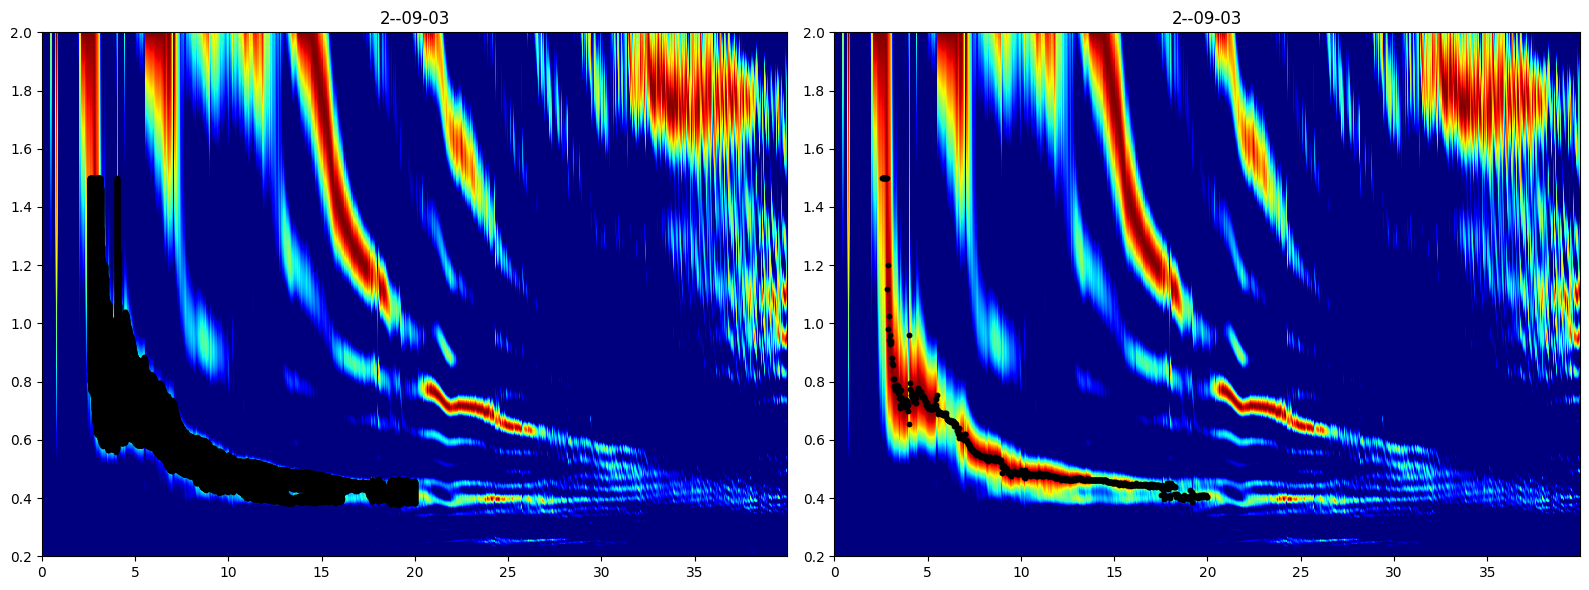

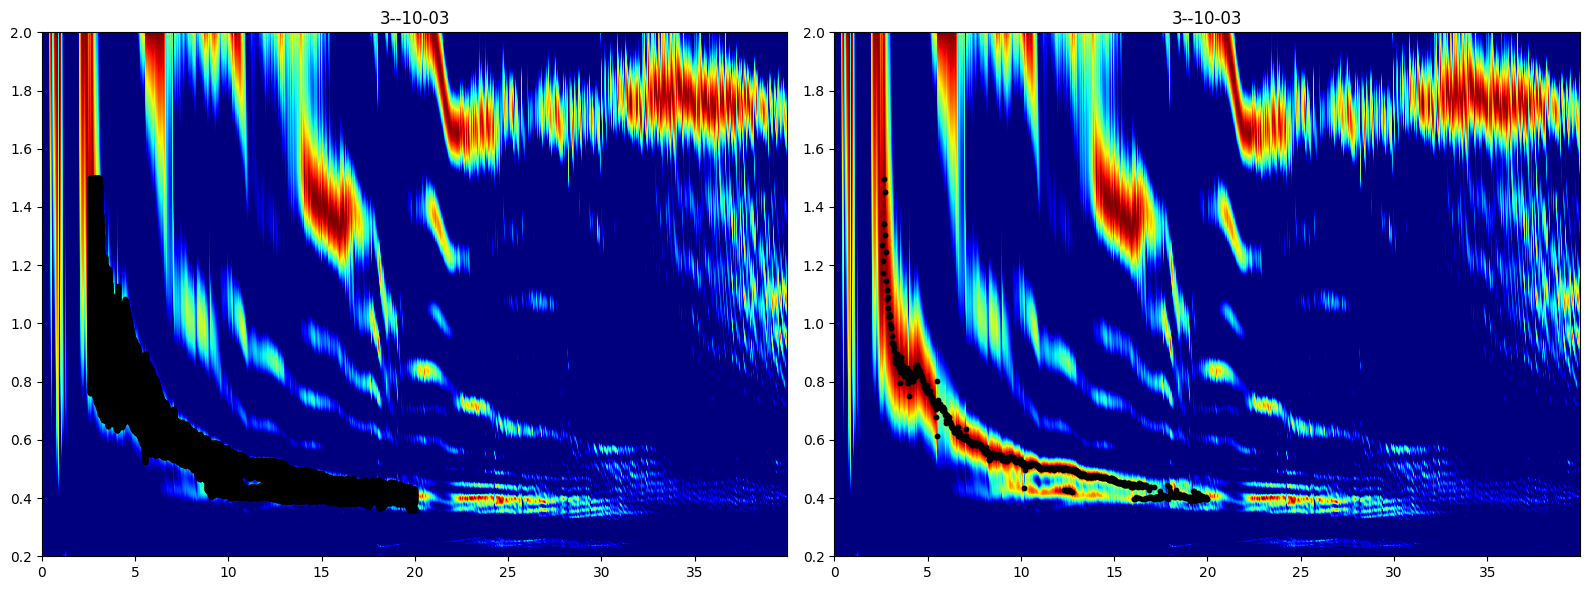

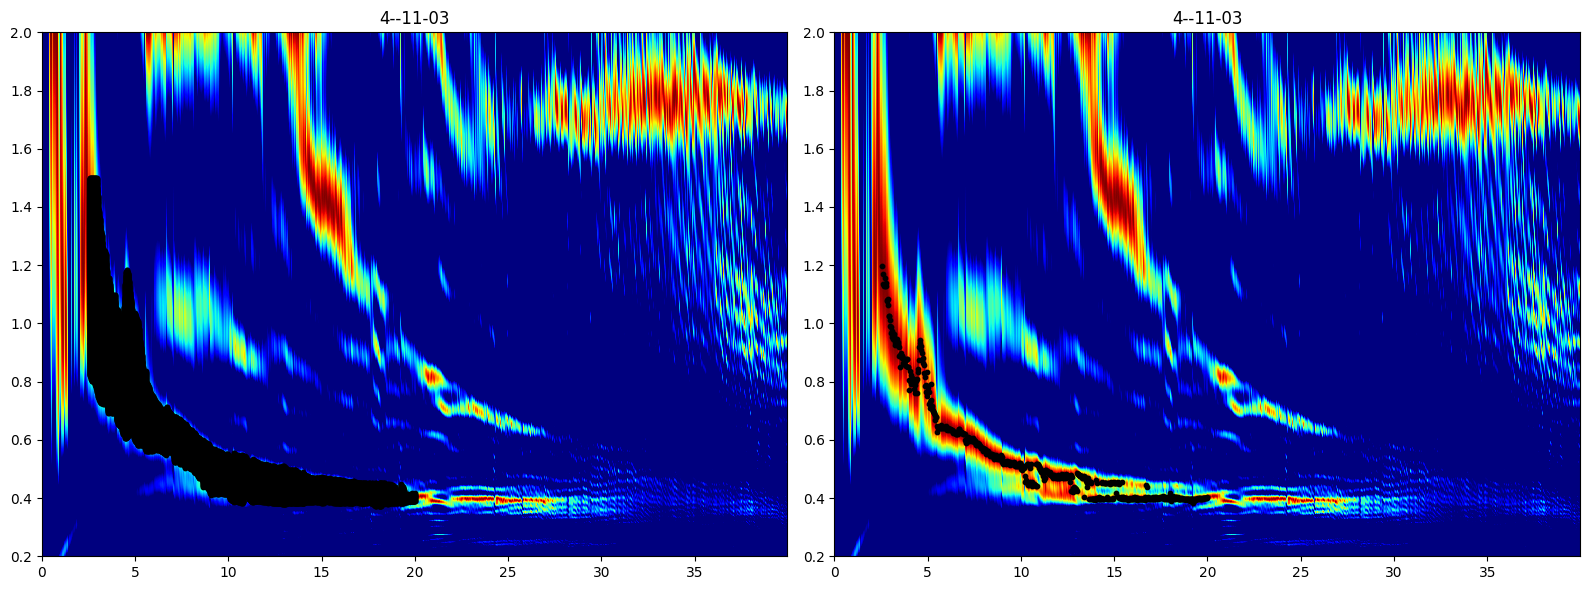

In [21]:
if flag_plot == 1:
    for key_subwork in key_subworks:  
        plot_disp(key_subwork)